In [1]:
# Install necessary libraries if not already installed
# !pip install transformers datasets pandas
# !pip install matplotlib

# Import necessary libraries
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
import torch



In [2]:
# Check for MPS and CUDA availability
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS is available")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Using CPU")




MPS is available


In [3]:
# Load the datasets from CSV files
train_df = pd.read_csv('data/train.csv')
valid_df = pd.read_csv('data/dev.csv')
test_df = pd.read_csv('data/test.csv')

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)


In [4]:
# Load the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('onlplab/alephbert-base')
label_mapping = {'contradiction': 0, 'entailment': 1, 'neutral': 2}


# Define a function to preprocess the input data
def preprocess_function(examples):
    # Tokenize the inputs (translation1 and translation2)
    inputs = tokenizer(
        examples['translation1'], 
        examples['translation2'], 
        truncation=True, 
        padding='max_length', 
        max_length=128  # Or another max length depending on your needs
    )
    
    # Map the annotator_labels to numerical labels if needed
    # inputs['labels'] = examples['gold_label']
    inputs['labels'] = [label_mapping[label] for label in examples['gold_label']]

    return inputs

# Apply the preprocessing function to the datasets
train_dataset = train_dataset.map(preprocess_function,batched=True)
# train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Load the pretrained BERT model for sequence classification

Map:   0%|          | 0/293298 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [5]:
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


In [6]:

model = BertForSequenceClassification.from_pretrained('onlplab/alephbert-base', num_labels=3)  # Change num_labels to match the number of classes in your NLI task
# tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
# model = BertModel.from_pretrained('onlplab/alephbert-base')
# Create a data collator that will dynamically pad the inputs during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.to(device)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,              # Number of epochs to train
    weight_decay=0.01,               # Strength of weight decay
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The instantiated 🤗 Transformers model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=valid_dataset,          # Evaluation dataset
    tokenizer=tokenizer,                 # Tokenizer
    data_collator=data_collator,          # Data collator
    compute_metrics=compute_metrics      # Custom metrics function
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/hadare/Documents/CodingProjects/SBERT/sbert/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
eval_results = trainer.evaluate()

print(f"Evaluation Results: {eval_results}")

# Fine-Tune the Model
trainer.train()

# Evaluate the Model
eval_results = trainer.evaluate()

print(f"Evaluation Results: {eval_results}")

# Save the fine-tuned model for future use
model.save_pretrained("your_model_directory")
tokenizer.save_pretrained("your_model_directory")

  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 1.1120027303695679, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.3448, 'eval_runtime': 38.4363, 'eval_samples_per_second': 130.085, 'eval_steps_per_second': 8.143}


  0%|          | 0/54996 [00:00<?, ?it/s]

{'loss': 0.9812, 'grad_norm': 8.168329238891602, 'learning_rate': 1.9818168594079573e-05, 'epoch': 0.03}
{'loss': 0.8815, 'grad_norm': 6.46674108505249, 'learning_rate': 1.963633718815914e-05, 'epoch': 0.05}
{'loss': 0.8388, 'grad_norm': 8.541193008422852, 'learning_rate': 1.945450578223871e-05, 'epoch': 0.08}
{'loss': 0.7981, 'grad_norm': 8.38892650604248, 'learning_rate': 1.9272674376318278e-05, 'epoch': 0.11}
{'loss': 0.7952, 'grad_norm': 9.508397102355957, 'learning_rate': 1.909084297039785e-05, 'epoch': 0.14}
{'loss': 0.7824, 'grad_norm': 7.208209991455078, 'learning_rate': 1.8909011564477418e-05, 'epoch': 0.16}
{'loss': 0.7669, 'grad_norm': 11.646167755126953, 'learning_rate': 1.8727180158556986e-05, 'epoch': 0.19}
{'loss': 0.7657, 'grad_norm': 5.550448894500732, 'learning_rate': 1.8545348752636555e-05, 'epoch': 0.22}
{'loss': 0.7575, 'grad_norm': 9.523566246032715, 'learning_rate': 1.8363517346716126e-05, 'epoch': 0.25}
{'loss': 0.7404, 'grad_norm': 7.511907577514648, 'learning_

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.599687397480011, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7546, 'eval_runtime': 37.139, 'eval_samples_per_second': 134.629, 'eval_steps_per_second': 8.428, 'epoch': 1.0}
{'loss': 0.5999, 'grad_norm': 9.894014358520508, 'learning_rate': 1.327223798094407e-05, 'epoch': 1.01}
{'loss': 0.5137, 'grad_norm': 13.78271770477295, 'learning_rate': 1.309040657502364e-05, 'epoch': 1.04}
{'loss': 0.5148, 'grad_norm': 12.74290657043457, 'learning_rate': 1.2908575169103208e-05, 'epoch': 1.06}
{'loss': 0.5064, 'grad_norm': 7.268828868865967, 'learning_rate': 1.2726743763182778e-05, 'epoch': 1.09}
{'loss': 0.5173, 'grad_norm': 8.556841850280762, 'learning_rate': 1.2544912357262346e-05, 'epoch': 1.12}
{'loss': 0.5253, 'grad_norm': 10.969468116760254, 'learning_rate': 1.2363080951341916e-05, 'epoch': 1.15}
{'loss': 0.5127, 'grad_norm': 9.24118423461914, 'learning_rate': 1.2181249545421484e-05, 'epoch': 1.17}
{'loss': 0.5209, 'grad_norm': 8.834582328796387, 'learning_rate'

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.596453070640564, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7664, 'eval_runtime': 37.154, 'eval_samples_per_second': 134.575, 'eval_steps_per_second': 8.424, 'epoch': 2.0}
{'loss': 0.4041, 'grad_norm': 14.296586990356445, 'learning_rate': 6.544475961888138e-06, 'epoch': 2.02}
{'loss': 0.3607, 'grad_norm': 13.009255409240723, 'learning_rate': 6.362644555967708e-06, 'epoch': 2.05}
{'loss': 0.3522, 'grad_norm': 15.864368438720703, 'learning_rate': 6.180813150047277e-06, 'epoch': 2.07}
{'loss': 0.362, 'grad_norm': 28.352888107299805, 'learning_rate': 5.998981744126846e-06, 'epoch': 2.1}
{'loss': 0.3709, 'grad_norm': 15.614493370056152, 'learning_rate': 5.817150338206415e-06, 'epoch': 2.13}
{'loss': 0.352, 'grad_norm': 14.010446548461914, 'learning_rate': 5.635318932285984e-06, 'epoch': 2.15}
{'loss': 0.3566, 'grad_norm': 17.821733474731445, 'learning_rate': 5.453487526365554e-06, 'epoch': 2.18}
{'loss': 0.3595, 'grad_norm': 18.766918182373047, 'learning_rate'

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.6620648503303528, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7728, 'eval_runtime': 37.2683, 'eval_samples_per_second': 134.162, 'eval_steps_per_second': 8.399, 'epoch': 3.0}
{'train_runtime': 22235.6346, 'train_samples_per_second': 39.571, 'train_steps_per_second': 2.473, 'train_loss': 0.5262135017290143, 'epoch': 3.0}


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.6620648503303528, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7728, 'eval_runtime': 37.0467, 'eval_samples_per_second': 134.965, 'eval_steps_per_second': 8.449, 'epoch': 3.0}


('your_model_directory/tokenizer_config.json',
 'your_model_directory/special_tokens_map.json',
 'your_model_directory/vocab.txt',
 'your_model_directory/added_tokens.json')

In [8]:
test_results = trainer.evaluate(test_dataset)

# Print the test results
print(f"Test Results: {test_results}")

  0%|          | 0/313 [00:00<?, ?it/s]

Test Results: {'eval_loss': 0.6986885666847229, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7676, 'eval_runtime': 37.0513, 'eval_samples_per_second': 134.948, 'eval_steps_per_second': 8.448, 'epoch': 3.0}


  0%|          | 0/313 [00:00<?, ?it/s]

Confusion Matrix:
[[1302  174  206]
 [ 124 1290  224]
 [ 220  214 1246]]


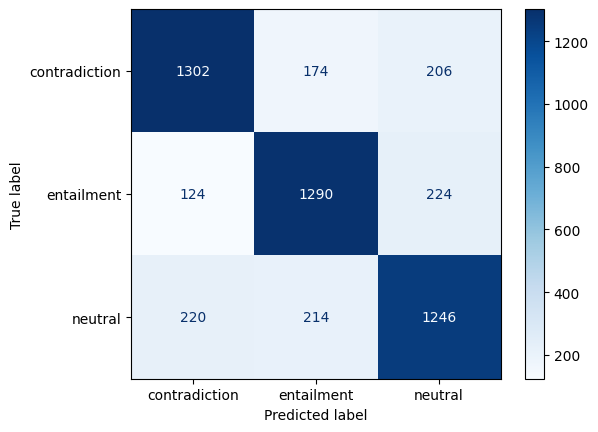

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import numpy as np

# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract the predicted labels (argmax of logits)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract the true labels
true_labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print(f"Confusion Matrix:\n{conf_matrix}")

# Optional: Plot the confusion matrix using ConfusionMatrixDisplay from sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_mapping.keys()))
disp.plot(cmap='Blues')


In [10]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

print(f"Accuracy from Confusion Matrix: {accuracy:.4f}")


Accuracy from Confusion Matrix: 0.7676


  0%|          | 0/313 [00:00<?, ?it/s]

Per-class Precision, Recall, F1-Score:
Class contradiction - Precision: 0.7910, Recall: 0.7741, F1-Score: 0.7825
Class entailment - Precision: 0.7688, Recall: 0.7875, F1-Score: 0.7780
Class neutral - Precision: 0.7434, Recall: 0.7417, F1-Score: 0.7426

Overall Micro-Averaged Metrics - Precision: 0.7676, Recall: 0.7676, F1-Score: 0.7676
Overall Macro-Averaged Metrics - Precision: 0.7677, Recall: 0.7678, F1-Score: 0.7677


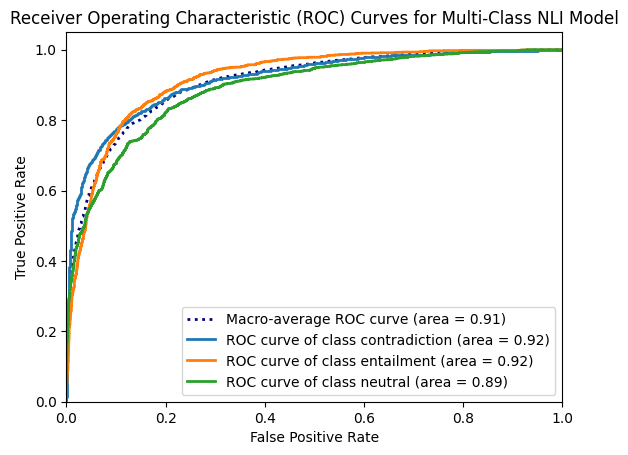

In [11]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming predictions and true labels are already computed
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Binarize the true labels for ROC-AUC computation (necessary for multi-class)
n_classes = len(label_mapping)  # Number of classes (e.g., 3 for 'contradiction', 'entailment', 'neutral')
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate Precision, Recall, and F1-Score for each class and overall (micro and macro)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None, labels=[0, 1, 2])
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

# Print Precision, Recall, and F1-Score for each class
print(f"Per-class Precision, Recall, F1-Score:")
for idx, label in enumerate(label_mapping.keys()):
    print(f"Class {label} - Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}, F1-Score: {f1[idx]:.4f}")

# Print overall metrics
print(f"\nOverall Micro-Averaged Metrics - Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-Score: {f1_micro:.4f}")
print(f"Overall Macro-Averaged Metrics - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")

# Compute ROC-AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions.predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class and the macro-average
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {list(label_mapping.keys())[i]} (area = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-Class NLI Model')
plt.legend(loc="lower right")
plt.show()
